1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [2]:
data = pd.read_csv("my_PJME_MW.csv", index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w = data.resample("W").mean().sort_index()
data_w.drop(columns=['year', 'hour','dayofweek','dayofmonth', 'dayofyear',\
                     'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
data_w.head(3)

,PJME_MW,month,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,1.0,1.0,1.0
2002-01-13,31487.386905,1.0,1.0,2.0
2002-01-20,31452.880952,1.0,1.0,3.0


2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [4]:
#Добавим разностей
diff1 =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0.0
data_w['diff1'] = data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = diff1

In [5]:
diff2 = np.array(data_w.iloc[2:,0].values - data_w.iloc[:-2,0].values).astype('float32') 
data_w['diff2'] = 0.0
data_w['diff2'] = data_w['diff2'].astype('float') 
data_w['diff2'].values[2:] = diff2

In [6]:
diff3 = np.array(data_w.iloc[3:,0].values - data_w.iloc[:-3,0].values).astype('float32') 
data_w['diff3'] = 0.0
data_w['diff3'] = data_w['diff3'].astype('float')
data_w['diff3'].values[3:] = diff3

In [7]:
diff4 = np.array(data_w.iloc[4:,0].values - data_w.iloc[:-4,0].values).astype('float32') 
data_w['diff4'] = 0.0
data_w['diff4'] = data_w['diff4'].astype('float')
data_w['diff4'].values[4:] = diff4

In [8]:
#Логарифм признака
diff1_d =(diff1) / data_w.iloc[1:,0].values
data_w['diff1_d'] = 0.0
data_w['diff1_d'] =  data_w['diff1_d'].astype('float') 
data_w['diff1_d'].values[1:] = np.array(diff1_d).astype('float32')

In [9]:
diff2_d =data_w.iloc[:,5] / data_w.iloc[:,0].values
data_w['diff2_d'] = 0.0
data_w['diff2_d'] =  data_w['diff2_d'].astype('float') 
data_w['diff2_d'].values[:] = np.array(diff2_d).astype('float32')

In [10]:
diff3_d =data_w.iloc[:,6] / data_w.iloc[:,0].values
data_w['diff3_d'] = 0.0
data_w['diff3_d'] =  data_w['diff3_d'].astype('float') 
data_w['diff3_d'].values[:] = np.array(diff3_d).astype('float32')

In [11]:
diff4_d =data_w.iloc[:,6] / data_w.iloc[:,0].values
data_w['diff4_d'] = 0.0
data_w['diff4_d'] =  data_w['diff4_d'].astype('float') 
data_w['diff4_d'].values[:] = np.array(diff4_d).astype('float32')

In [12]:
#Скользящее среднее
for i in range(4,10):    
    data_w[f'd_w{i}']=data_w['PJME_MW'].rolling(window=i).mean()

In [13]:
#экспонентциальная средняя
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [14]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_09'] = exponential_smoothing(data_w['PJME_MW'], 0.09)

In [15]:
p = 10
for i in range(p):
    data_w['d1_'+str(p-i)]=0
    data_w['d1_'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [16]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 33 columns):
PJME_MW       866 non-null float64
month         866 non-null float64
quarter       866 non-null float64
weekofyear    866 non-null float64
diff1         866 non-null float64
diff2         866 non-null float64
diff3         866 non-null float64
diff4         866 non-null float64
diff1_d       866 non-null float64
diff2_d       866 non-null float64
diff3_d       866 non-null float64
diff4_d       866 non-null float64
d_w4          863 non-null float64
d_w5          862 non-null float64
d_w6          861 non-null float64
d_w7          860 non-null float64
d_w8          859 non-null float64
d_w9          858 non-null float64
exp_0_01      866 non-null float64
exp_0_03      866 non-null float64
exp_0_06      866 non-null float64
exp_0_07      866 non-null float64
exp_0_09      866 non-null float64
d1_10         866 non-null int64
d1_9          866 non-null

In [17]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.preprocessing import StandardScaler

In [18]:
scl_target=StandardScaler() 
# p = 14
h=4
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(852, 1)

In [19]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(852, 33)

In [20]:
#SelectKBest 
sfk =SelectKBest(f_regression, k=6)
X_new1 =sfk.fit_transform(X, y.ravel())
column_names_KBest = data_w.columns[sfk.get_support()]
column_names_KBest

Index(['PJME_MW', 'diff3', 'diff4', 'diff2_d', 'diff3_d', 'diff4_d'], dtype='object')

In [21]:
#SelectPercentile
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
column_names_Percentile = data_w.columns[sfp.get_support()]
column_names_Percentile

Index(['diff3', 'diff4', 'diff3_d', 'diff4_d'], dtype='object')

In [22]:
#GradientBoostingRegressor
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 6)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
column_names_GradientBoosting = data_w.columns[sfm.get_support()]
column_names_GradientBoosting

Index(['PJME_MW', 'month', 'weekofyear', 'diff4', 'd1_5', 'd1_4'], dtype='object')

In [23]:
The_best = np.concatenate([['PJME_MW'], column_names_KBest, column_names_Percentile, column_names_GradientBoosting])

In [24]:
The_best = np.array(list(set(The_best)), dtype='object')
The_best

array(['diff4', 'diff3', 'PJME_MW', 'diff4_d', 'd1_4', 'd1_5', 'diff3_d',
       'diff2_d', 'weekofyear', 'month'], dtype=object)

In [25]:
data_best_w4 = data_w[The_best]
data_best_w4.head()

,diff4,diff3,PJME_MW,diff4_d,d1_4,d1_5,diff3_d,diff2_d,weekofyear,month
Date,,,,,,,,,,
2002-01-06,0.000000,0.000000,32392.160839,0.000000,0,0,0.000000,0.000000,1.0,1.000000
2002-01-13,0.000000,0.000000,31487.386905,0.000000,0,0,0.000000,0.000000,2.0,1.000000
2002-01-20,0.000000,0.000000,31452.880952,0.000000,0,0,0.000000,-0.029863,3.0,1.000000
2002-01-27,0.000000,-2250.631104,30141.529762,-0.074669,0,0,-0.074669,-0.044651,4.0,1.000000
2002-02-03,-3195.672852,-2290.898926,29196.488095,-0.078465,0,0,-0.078465,-0.077283,5.0,1.428571


In [26]:
X = pd.DataFrame(X, columns=data_w.columns)

In [27]:
X_best = X[The_best]

In [28]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

c:\users\a.kraev\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


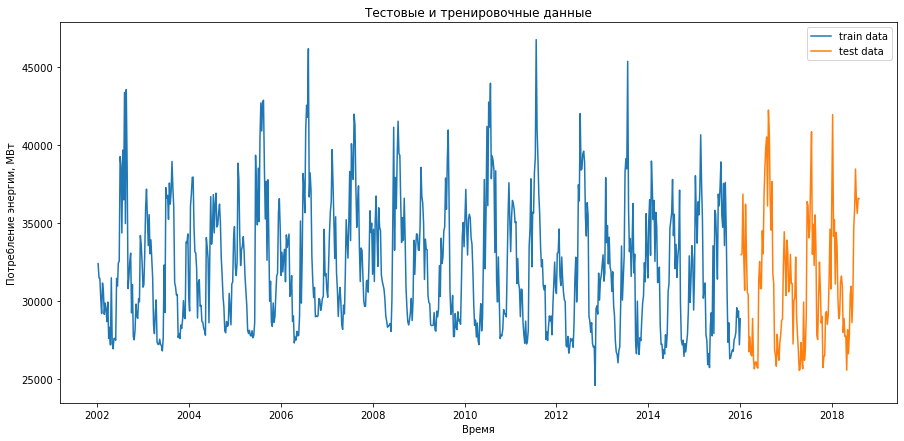

In [29]:
train, test = split_data( data_best_w4, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [30]:
X_train =X_best.iloc[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_best.iloc[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
model_g_4w = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_g_4w.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
y_test_pred_4w = model_g_4w.predict(X_test)

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_4w) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_4w) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_4w)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.5249740832436207 
ошибка mae  :   0.5647771074365235 
оценка R2 :   0.513070211653194


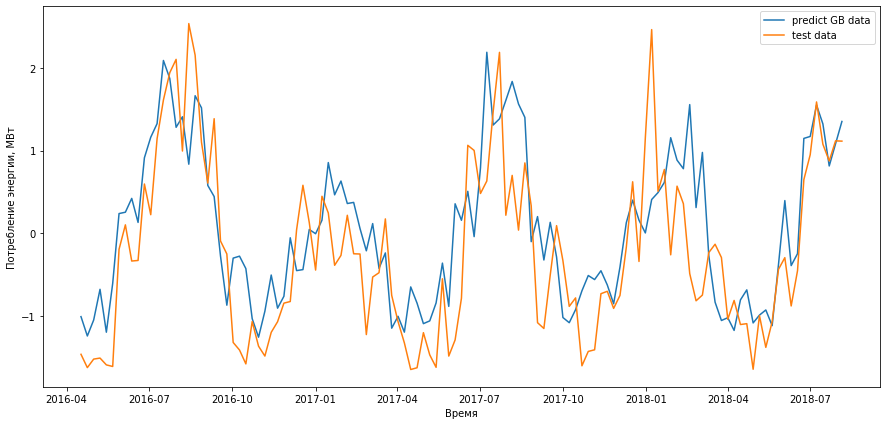

In [35]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_4w, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [36]:
h=1
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

In [37]:
#SelectKBest 
sfk =SelectKBest(f_regression, k=6)
X_new1 =sfk.fit_transform(X, y.ravel())
column_names_KBest = data_w.columns[sfk.get_support()]
column_names_KBest

Index(['PJME_MW', 'd_w4', 'd_w5', 'd_w6', 'd_w7', 'd_w8'], dtype='object')

In [38]:
#SelectPercentile
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
column_names_Percentile = data_w.columns[sfp.get_support()]
column_names_Percentile

Index(['PJME_MW', 'd_w4', 'd_w5', 'd_w6'], dtype='object')

In [39]:
#GradientBoostingRegressor
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 6)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
column_names_GradientBoosting = data_w.columns[sfm.get_support()]
column_names_GradientBoosting

Index(['PJME_MW', 'weekofyear'], dtype='object')

In [40]:
The_best = np.concatenate([['PJME_MW'], column_names_KBest, column_names_Percentile, column_names_GradientBoosting])
The_best = np.array(list(set(The_best)), dtype='object')
The_best

array(['d_w6', 'd_w8', 'PJME_MW', 'd_w7', 'weekofyear', 'd_w5', 'd_w4'],
      dtype=object)

In [41]:
data_best_w1 = data_w[The_best]

In [42]:
X = pd.DataFrame(X, columns=data_w.columns)
X_best = X[The_best]

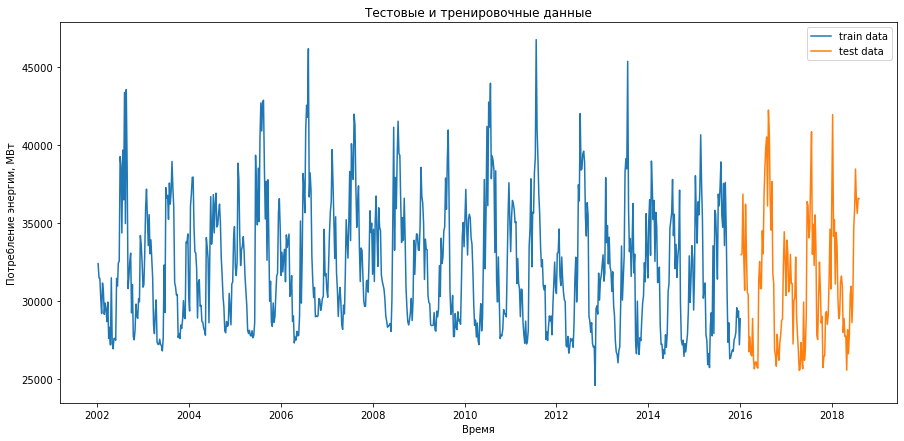

In [43]:
train, test = split_data( data_best_w1, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [44]:
X_train =X_best.iloc[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_best.iloc[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [45]:
model_g_1w = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_g_1w.fit( X_train, y_train )
y_test_pred_1w = model_g_1w.predict(X_test)

In [46]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_1w) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_1w) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_1w)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.4287138445264279 
ошибка mae  :   0.5238225201206376 
оценка R2 :   0.6020221863692554


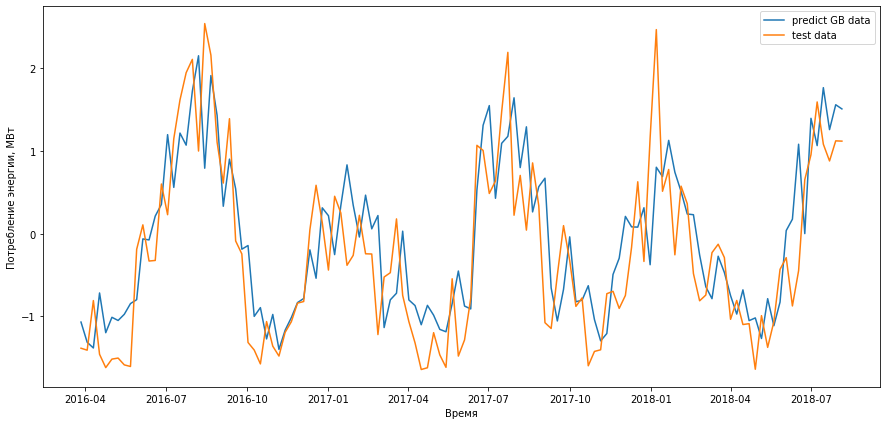

In [47]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_1w, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

In [48]:
X_test_100 = np.array(X_test.copy())
y_test_100 = y_test.copy()

In [53]:
X_test.head(1)

,d_w6,d_w8,PJME_MW,d_w7,weekofyear,d_w5,d_w4
731,-0.38736,-0.337618,-1.102244,-0.403538,-1.034154,-0.691195,-0.910412


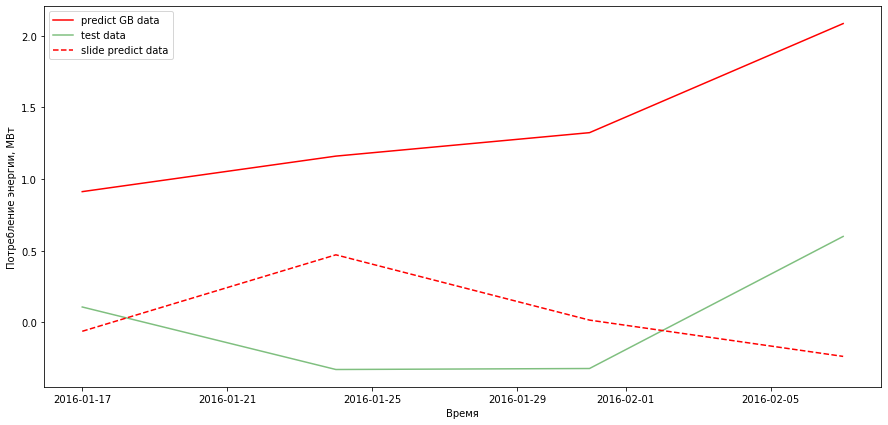

In [54]:
#d_w6 	d_w8 	PJME_MW 	d_w7 	weekofyear 	d_w5 	d_w4

N10 = 100
for i in range(p,N10+p):
    y_test_100[i] = model_g_1w.predict(X_test_100[i,:].reshape(1,X_test_100.shape[1]))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    
    # заполняем вектор для прогноза следующей точки
    # d_w8
    X_test_100[i+1,1] = np.mean(X_test_100[i-7:i+1,2])
    #weekofyear
    X_test_100[i+1,4] = X_test_100[i,1]
    # PJME_MW
    X_test_100[i+1,2] = (y_i[0] - scl_x.mean_[0]) / scl_x.scale_[0]
    #d_w6
    X_test_100[i+1,0] = np.mean(X_test_100[i-5:i,2])
    #d_w5
    X_test_100[i+1,5] = np.mean(X_test_100[i-4:i,2]) 
    #d_w7
    X_test_100[i+1,3] = np.mean(X_test_100[i-6:i,2])
    #d_w4        
    X_test_100[i+1,6] = np.mean(X_test_100[i-3:i,2])
    
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:4+1],y_test_pred_4w[p:4+p], 'r',label='predict GB data' )
plt.plot(test.index[1:4+1],y_test[p:4+p], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:4+1],y_test_100[p:4+p], '--r',label='slide predict data')
plt.legend()
plt.show()  

In [55]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    #print(np.abs((y_true - y_pred) / y_true))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
for i in range(10):
    erorr = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[10*i:10*i+10]),\
                                       y_pred = scl_target.inverse_transform(y_test_100[10*i:10*i+10]))
    print(erorr)

0.0
10.625730842310636
11.931865721806235
9.423180285775693
9.720271072747705
18.544771213870863
14.789785291297694
10.337945166287339
19.596743934070194
8.855504937670975


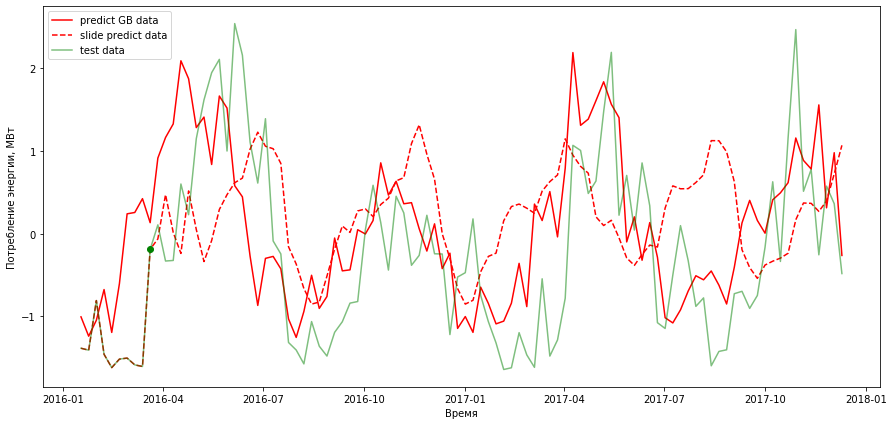

In [57]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_4w[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show()    

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Если смотреть на график предсказания, а не на ошибку то видно как авторекурсия вошла начала предсказывать с определенным циклом. Цикл предсказания не совпал с циклом реальных данных и мы получили скачущую ошибку.